## Predictive Maintenance Example
#### Supplement to 'Operationalizing Predictive Maintenance on a Distributed Network of Equipment'
###### Melissa Perry
###### UWEX Data Science Masters Program Capstone
###### December 12, 2021

#### Predicting the Remaining Useful Life of Equipment
The following code will demonstrate how to use mechanical sensor data to predict when a piece of equipment will fail based on its past failure behavior. This kind of approach can be applied in any setting with a similar data collection strategy in place for equipment maintenance. 

In [71]:
##import libraries and bring in datasets. 
import pandas as pd
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

#### Import and Explore Data
We will utilize a widely known time series dataset from the NASA Prognostics Center of Excellence for our demonstration of predictive maintenance algorithms. This dataset simulates failure in a set of aeronautical turbofan engines. It comes pre-split into train and test set.  This is important for training a machine learning model, since we don't want to "leak" any information from the training dataset into the test dataset. Information about the column names is presented in the accompanying Readme.txt. The first steps will be to explore the structure of the dataset and add some column names. 

A. Saxena and K. Goebel (2008). "Turbofan Engine Degradation Simulation Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA


In [3]:
#import the dataset and examine some basic info about it. 
train = pd.read_csv('data/train_FD001.txt', header=None, sep=" ")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20631 non-null  int64  
 1   1       20631 non-null  int64  
 2   2       20631 non-null  float64
 3   3       20631 non-null  float64
 4   4       20631 non-null  float64
 5   5       20631 non-null  float64
 6   6       20631 non-null  float64
 7   7       20631 non-null  float64
 8   8       20631 non-null  float64
 9   9       20631 non-null  float64
 10  10      20631 non-null  float64
 11  11      20631 non-null  float64
 12  12      20631 non-null  float64
 13  13      20631 non-null  float64
 14  14      20631 non-null  float64
 15  15      20631 non-null  float64
 16  16      20631 non-null  float64
 17  17      20631 non-null  float64
 18  18      20631 non-null  float64
 19  19      20631 non-null  float64
 20  20      20631 non-null  float64
 21  21      20631 non-null  int64  
 22

In [4]:
#examine the first 5 rows
train.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [5]:
#drop last 2 columns, because they have no values
train=train.iloc[:, :-2]

In [6]:
#Add column names to the dataframe, as specified in the accompanying readme.txt and Damage Propogation Modeling white paper. 
cols=['unit_number','time_in_cycles','setting_1','setting_2','setting_3']
cols2  = ['T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

cols = cols + cols2

train.columns = cols

In [7]:
#check that it worked. 
train.head()

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Setting up the Outcome Variable
The Readme.txt file explains that the training data files have a row for every run of the turbofan engine until failure, while the test data files have rows that stop at an unspecified time. The idea will be to use the information gained in the training files, where the failure outcome is certain, to have a machine learning model learn as much about signature behaviors before failure occurs. We can then feed the testing dataset into the model and predict the remaining useful life of each turbofan engine at each point in time. 

The first step to preparing the data for the machine learning model will be to create a remaining useful life variable in the training dataset. Each 'unit number' represents a turbofan engine, and for each engine, each 'time in cycles' represents a run. The very last run , or row, for each unit is the row right before the time of failure. The remaining useful life at the last row will be 0. Because the second column displays 'time in cycles', we need to count the difference between that time point and the maximum cycle count in order to calculate the remaining useful life during each run. We will label this column 'RUL,' and it serves as our outcome variable, or the variable we are trying to predict. 

In [8]:
#calculate a remaining useful life value, and confirm it worked.
train['RUL'] = train.groupby(['unit_number'])['time_in_cycles'].transform(max) - train['time_in_cycles']
train.head()

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [9]:
#examine the end of the dataset to confirm the RUL calculation is working throughout the dataset. 
train.tail()

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,2388.26,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0


### Examining Correlation between Predictor Variables, or sensor readings. 
Machine learning models are most effective when each predictor variable learns a unique piece of information about the movement towards the outcome variable. When two or more predictors are correlated, they contribute the same information to the model, and interfere with its effectiveness. We refer to this concept as multicollinearity. We are going to begin by examining the correlation between all the predictor variables with one another visually. 

Then, we will use a tool called variance inflation factors to determine if we run the risk of multicollinearity in our model. We will perform a Principal Components Analysis (PCA) to optimize the number of variables we select for those that provide the most unique variance in the dataset. 

In [10]:
# the independent variables set
X = train.iloc[:, 2:26]

#set up a correlation matrix
cormat = X.corr()
round(cormat,2)

,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,P15,P30,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
setting_1,1.00,0.01,NaN,NaN,0.01,-0.01,0.01,NaN,-0.00,-0.01,...,-0.00,0.00,-0.00,0.01,NaN,0.00,NaN,NaN,-0.01,-0.01
setting_2,0.01,1.00,NaN,NaN,0.01,0.01,0.01,NaN,0.01,-0.02,...,-0.01,0.02,-0.01,0.01,NaN,0.01,NaN,NaN,-0.01,-0.01
setting_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T24,0.01,0.01,NaN,NaN,1.00,0.60,0.71,NaN,0.13,-0.70,...,-0.72,0.66,0.18,0.68,NaN,0.63,NaN,NaN,-0.66,-0.67
T30,-0.01,0.01,NaN,NaN,0.60,1.00,0.68,NaN,0.12,-0.66,...,-0.68,0.60,0.24,0.64,NaN,0.60,NaN,NaN,-0.63,-0.63
T50,0.01,0.01,NaN,NaN,0.71,0.68,1.00,NaN,0.15,-0.79,...,-0.82,0.75,0.19,0.76,NaN,0.70,NaN,NaN,-0.75,-0.75
P2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P15,-0.00,0.01,NaN,NaN,0.13,0.12,0.15,NaN,1.00,-0.16,...,-0.16,0.16,-0.00,0.15,NaN,0.13,NaN,NaN,-0.14,-0.14
P30,-0.01,-0.02,NaN,NaN,-0.70,-0.66,-0.79,NaN,-0.16,1.00,...,0.81,-0.76,-0.11,-0.75,NaN,-0.69,NaN,NaN,0.74,0.74


In [11]:
# Examine basic descriptive characteristics about the predictor variables to assess how they vary across the dataset. 
X.describe()

,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,P15,P30,...,phi,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32
count,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


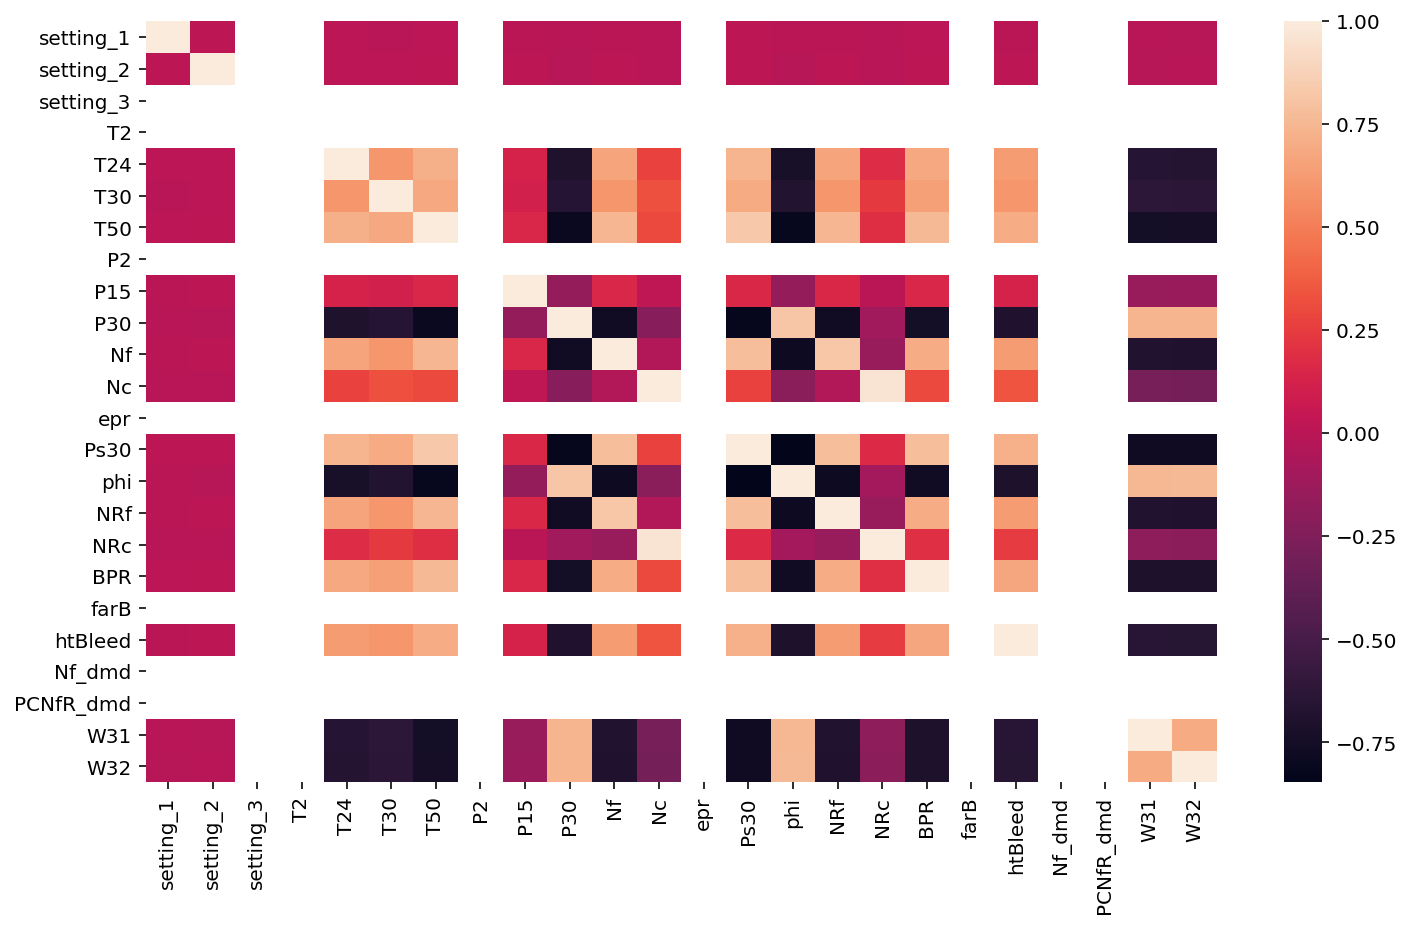

In [12]:
#examine a correlation heatmap. 
sns.heatmap(cormat);

The white spaces in this heatmap not only make it difficult to read, they indicate some of the predictor variables are not varying at all. We confirm this by examining the descriptive statistics in the block above for predictors like "T2", and "P2". These will be unhelpful in training our model, so we will drop them. 

We will make one exception to this practice: demanded fan speed variables must express some level of necessary fan speed to cool the engine. Because we also have two fan speed sensor variables, I will be interested in assessing the difference between the two. Perhaps an increasing difference could mean the engine is getting closer to failure and may overheat. 

In [13]:
#Add difference variables. 
X['Nf_diff']=X['Nf']-X['Nf_dmd']
X['NRf_diff'] = X['NRf']-X['PCNfR_dmd']

In [14]:
#remove the unneccessary predictors and confirm it worked.
X = X.drop(['setting_3', 'T2', 'P2','epr','farB','Nf_dmd','PCNfR_dmd'], axis=1)
X.head()

,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0.06,2288.02
1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0.04,2288.07
2,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0.08,2288.03
3,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0.11,2288.08
4,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0.06,2288.04


In [15]:
#Examine the cleaned up correlation matrix
cormat = X.corr()
round(cormat,2)

,setting_1,setting_2,T24,T30,T50,P15,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
setting_1,1.00,0.01,0.01,-0.01,0.01,-0.00,-0.01,-0.00,-0.00,0.01,-0.00,0.00,-0.00,0.01,0.00,-0.01,-0.01,-0.00,0.00
setting_2,0.01,1.00,0.01,0.01,0.01,0.01,-0.02,0.01,-0.01,0.01,-0.01,0.02,-0.01,0.01,0.01,-0.01,-0.01,0.01,0.02
T24,0.01,0.01,1.00,0.60,0.71,0.13,-0.70,0.66,0.27,0.74,-0.72,0.66,0.18,0.68,0.63,-0.66,-0.67,0.66,0.66
T30,-0.01,0.01,0.60,1.00,0.68,0.12,-0.66,0.60,0.32,0.70,-0.68,0.60,0.24,0.64,0.60,-0.63,-0.63,0.60,0.60
T50,0.01,0.01,0.71,0.68,1.00,0.15,-0.79,0.75,0.30,0.83,-0.82,0.75,0.19,0.76,0.70,-0.75,-0.75,0.75,0.75
P15,-0.00,0.01,0.13,0.12,0.15,1.00,-0.16,0.15,0.02,0.16,-0.16,0.16,-0.00,0.15,0.13,-0.14,-0.14,0.15,0.16
P30,-0.01,-0.02,-0.70,-0.66,-0.79,-0.16,1.00,-0.77,-0.22,-0.82,0.81,-0.76,-0.11,-0.75,-0.69,0.74,0.74,-0.77,-0.76
Nf,-0.00,0.01,0.66,0.60,0.75,0.15,-0.77,1.00,-0.03,0.78,-0.79,0.83,-0.14,0.70,0.63,-0.69,-0.69,1.00,0.83
Nc,-0.00,-0.01,0.27,0.32,0.30,0.02,-0.22,-0.03,1.00,0.27,-0.21,-0.03,0.96,0.29,0.34,-0.29,-0.29,-0.03,-0.03
Ps30,0.01,0.01,0.74,0.70,0.83,0.16,-0.82,0.78,0.27,1.00,-0.85,0.78,0.16,0.78,0.72,-0.77,-0.77,0.78,0.78


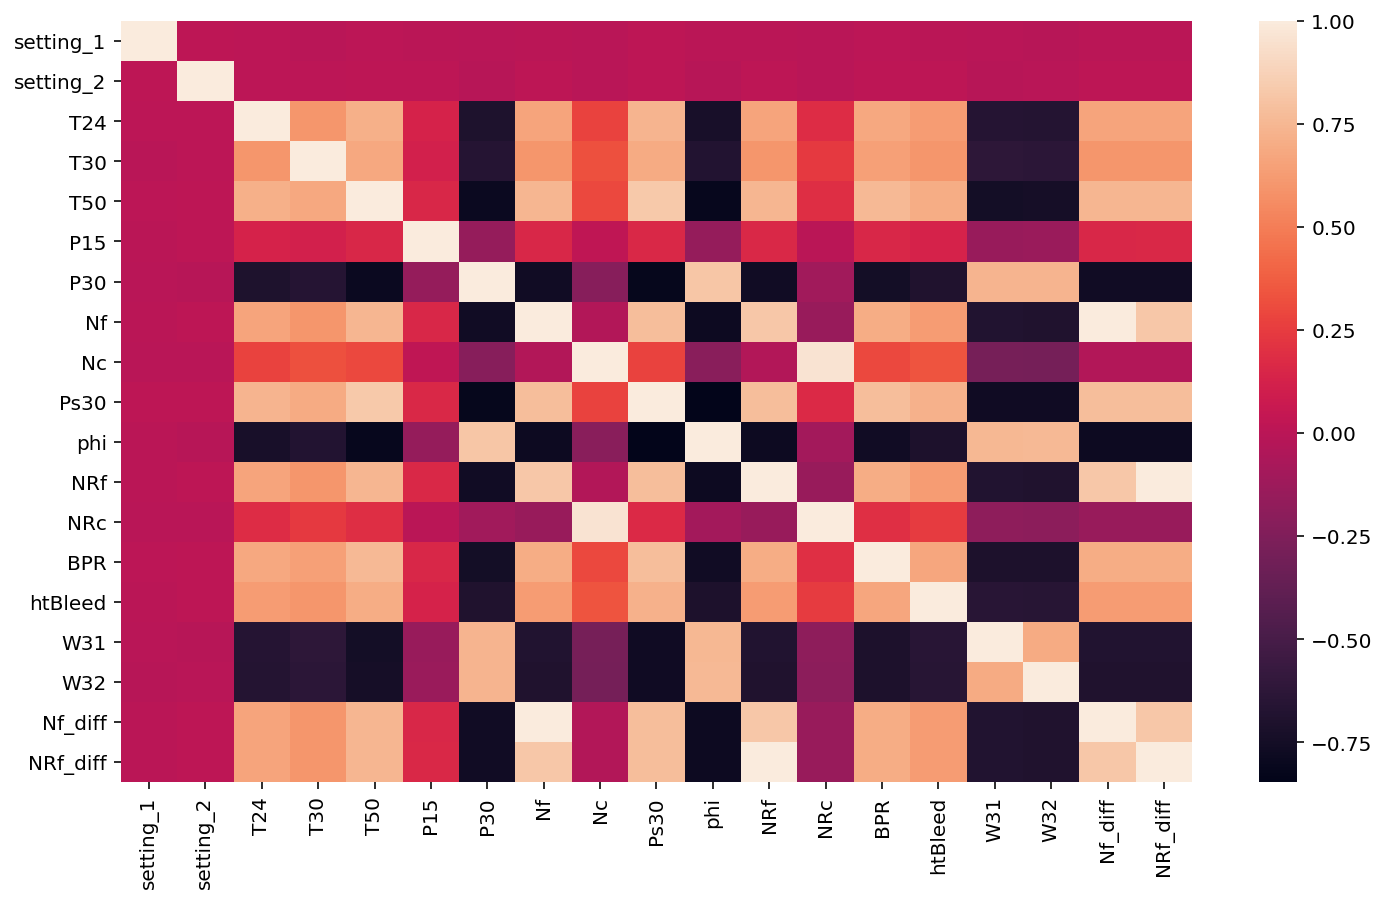

In [16]:
sns.heatmap(cormat);

### Interpret Correlation Map
* NRc (corrected core speed, rpm) and Nc (physical core speed, rpm) are highly correlated. Because the corrected core speed is some clear function of the core speed, we will drop one of them, leaving only one of the two. 
* Our diff variables also are perfectly correlated with their original sensor measurements, so we will drop the originals.

In [17]:
#remove additional correlated predictors and confirm it worked.
X = X.drop(['Nc','Nf','NRf'], axis=1)
X.head()

,setting_1,setting_2,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,47.47,521.66,8138.62,8.4195,392,39.06,23.4190,0.06,2288.02
1,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,0.04,2288.07
2,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,0.08,2288.03
3,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,0.11,2288.08
4,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,0.06,2288.04


### Apply the same transformations to test dataset.
We will have to repeat the same steps to prepare the test dataset to feed into our model, with the exception of preparing a RUL field, which we will attempt to predict. Let's review and summarize steps we ultimately took and write a function to handle the task on the test dataset or any other text file available from the NASA Turbofan Engine set.

In [19]:
#Write the function
def prep_data(df):
    import pandas as pd
    
    #Drop last 2 columns
    df = df.iloc[:, :-2]
    
    #Apply column names
    cols=['unit_number','time_in_cycles','setting_1','setting_2','setting_3',
          'T2','T24','T30','T50','P2','P15','P30','Nf','Nc','epr','Ps30','phi',
          'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']
    df.columns = cols
    
    #Add difference variables. 
    df['Nf_diff']=df['Nf']-df['Nf_dmd']
    df['NRf_diff'] = df['NRf']-df['PCNfR_dmd']

    #Drop correlated sensor readings, keeping only unique values. 
    df = df.drop(['setting_3', 'T2', 'P2','epr','farB','Nf_dmd','PCNfR_dmd','Nc','Nf','NRf'], axis=1)
    
    return(df)

In [20]:
#test the function
test = pd.read_csv('data/test_FD001.txt', header=None, sep=" ")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       13096 non-null  int64  
 1   1       13096 non-null  int64  
 2   2       13096 non-null  float64
 3   3       13096 non-null  float64
 4   4       13096 non-null  float64
 5   5       13096 non-null  float64
 6   6       13096 non-null  float64
 7   7       13096 non-null  float64
 8   8       13096 non-null  float64
 9   9       13096 non-null  float64
 10  10      13096 non-null  float64
 11  11      13096 non-null  float64
 12  12      13096 non-null  float64
 13  13      13096 non-null  float64
 14  14      13096 non-null  float64
 15  15      13096 non-null  float64
 16  16      13096 non-null  float64
 17  17      13096 non-null  float64
 18  18      13096 non-null  float64
 19  19      13096 non-null  float64
 20  20      13096 non-null  float64
 21  21      13096 non-null  int64  
 22

In [21]:
#run the function on the dataset and examine the results and see if it worked.
test = prep_data(test)
test.head()

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,21.61,553.90,47.20,521.72,8125.55,8.4052,392,38.86,23.3735,0.04,2288.03
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,21.61,554.85,47.50,522.16,8139.62,8.3803,393,39.02,23.3916,0.01,2288.06
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,21.61,554.11,47.50,521.97,8130.10,8.4441,393,39.08,23.4166,0.05,2288.03
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,21.61,554.07,47.28,521.38,8132.90,8.3917,391,39.00,23.3737,0.03,2288.05
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,21.61,554.16,47.31,522.15,8129.54,8.4031,390,38.99,23.4130,0.01,2288.03


In [124]:
# Splitting the X and Y into the
# Training set and Testing set

X_train = pd.read_csv('data/train_FD001.txt', header=None, sep=" ")
X_train = prep_data(X_train)
y_train= X_train.groupby(['unit_number'])['time_in_cycles'].transform(max) - X_train['time_in_cycles']
y_train=y_train.rename("RUL")
X_test = test

In [64]:
#Calculate RUL for each value in the y dataset 
y_test = pd.read_csv('data/RUL_FD001.txt', header=None, sep=" ")
unit_num = list(range(1,101))
y_test['unit_number'] = unit_num
y_test['final_RUL'] = y_test[0]
y_test = y_test.drop([0,1],axis=1)
y_test = X_test[["unit_number", "time_in_cycles"]].merge(y_test, left_on='unit_number', right_on='unit_number')
y_test['RUL'] = y_test.groupby(['unit_number'])['time_in_cycles'].transform(max) + y_test['final_RUL'] - y_test['time_in_cycles']

In [65]:
#test that this calculation works on the last unit number in the test set. 
y_test.loc[y_test['unit_number']==100]

,unit_number,time_in_cycles,final_RUL,RUL
12898,100,1,20,217
12899,100,2,20,216
12900,100,3,20,215
12901,100,4,20,214
12902,100,5,20,213
...,...,...,...,...
13091,100,194,20,24
13092,100,195,20,23
13093,100,196,20,22
13094,100,197,20,21


In [67]:
#Set y_test equal to only the 'RUL' value. 
y_test = y_test['RUL']

In [75]:
#Train an Initial Model and assess its performance. 
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# The coefficients
print("Coefficients: \n", model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Coefficients: 
 [ 2.84246329e-01 -4.19868045e-01  4.68887989e+00  2.70383918e+03
 -5.11439758e+00 -2.65688008e-01 -4.61927717e-01 -6.08363250e+02
  4.32416105e+00 -2.35413048e+01  5.74998367e+00 -2.68826393e-01
 -8.13422559e+01 -9.62329332e-01  9.58772358e+00  2.35056949e+01
 -2.57868003e+01 -2.05163566e+01]
Mean squared error: 1874.77
Coefficient of determination: 0.46


### Exploratory Data Analysis
Our very first model doesn't explain much of the variance remaining useful life over the predictors. Let's explore the data visually to determine how we can improve our model.

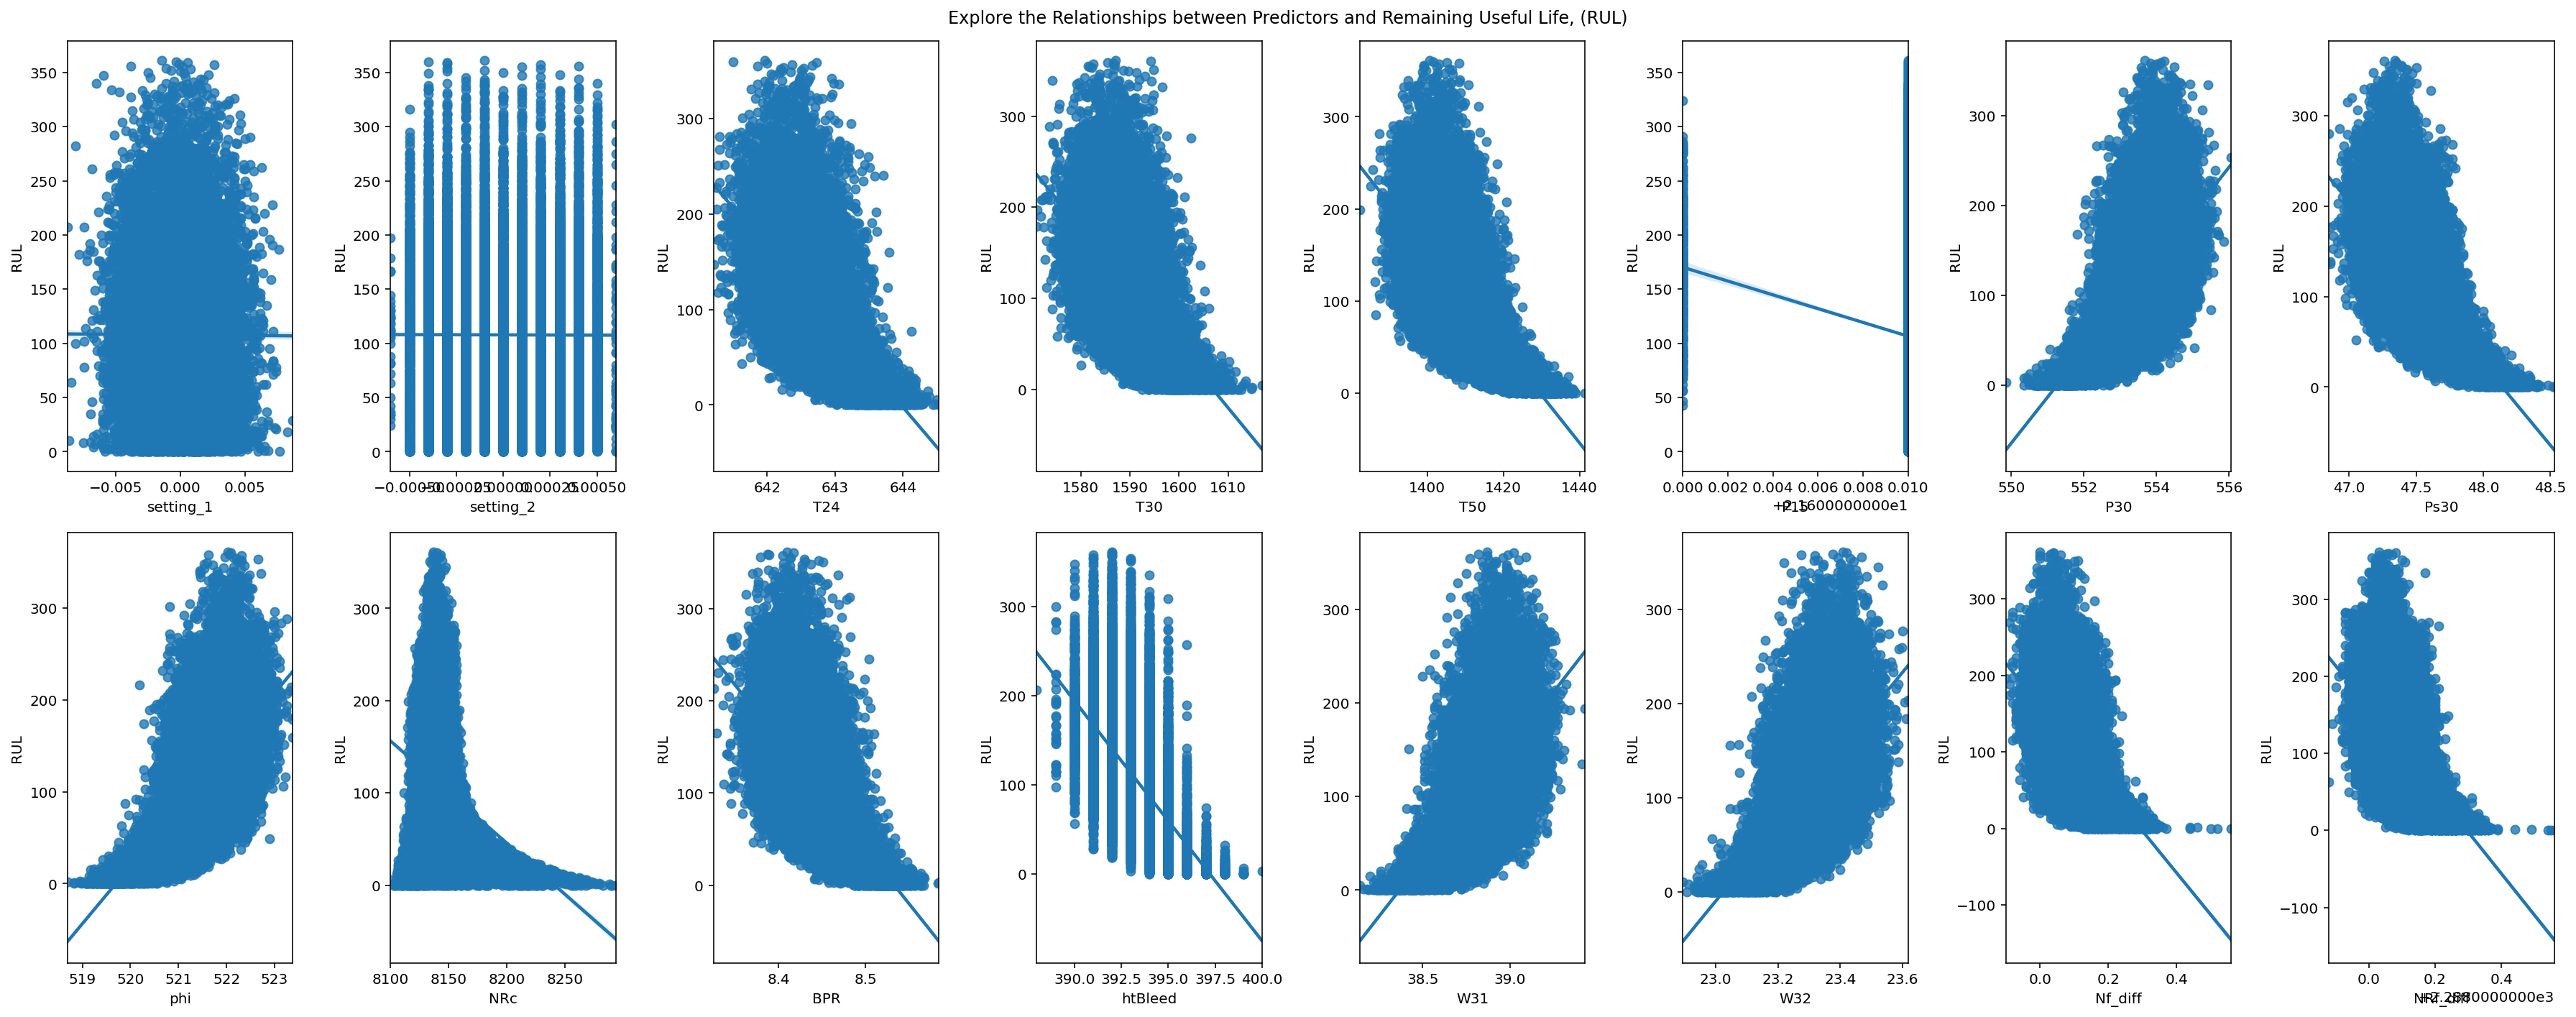

In [140]:
### PLOT BUILD
fig, ax = plt.subplots(2,8, figsize=(25,10))

for i,col in enumerate(X_train.columns[2:]):
    if i <= 7:
        sns.regplot(x=X_train[col], y=y_train, ax=ax[0,i])
    else:
        sns.regplot(x=X_train[col], y=y_train, ax=ax[1,i-8])   

# ax[1,3].axis('off')                  # HIDES AXES ON LAST ROW AND COL

fig.suptitle('Explore the Relationships between Predictors and Remaining Useful Life, (RUL)')
fig.tight_layout()
fig.subplots_adjust(top=0.95)

plt.show()
plt.clf()
plt.close()

Here are some high level observations from the scatter plots, and the implication it will have for our modeling efforts:
* The variables are on completely different scales. We will have to normalize the data set so that the largest numbers don't take the most control of the model.
* Temperature in all three outlets, LPC, HPC, and LPT increase as Remaining Useful life decreases. There is similar behavior for pressure at the HPC outlet (Ps30),Bypass Ratio (BPR), bleed enthalpy (htBleed), and the difference in fan speeds from what's demanded (Nf_diff, NRf_diff)  We will need variables that capture the increases over time. 
* The variance of Core Fan Speed (NRc) markedly increases in between 100 and 0 remaining useful cycles. This may be an effective predictor on its own. We should capture change in variance for this sensor in our feature extraction work. 
* The total pressure at the HPC outlet (P30), ratio of fuel flow to pressure at HPC outlet (phi), and coolant bleed sensors (W31 and W32) show a decrease as an engine approaches end of life. Just as in the variables that increased, we should monitor change in these sensors to capture the decreases over time. 

### Perform Feature Extraction
Now we will collect features in the time windows before the failure occurred for each unit. We need to transform our dataset completely, because the sensor measures in the moment leading up to failure will be no use in predicting the remaining useful life. This is intuitive because we cannot know the future when we feed data into our model. Our model will need to learn the signatures of moments leading up to failure, not right at the time of failure. 

https://towardsdatascience.com/timeseries-data-munging-lagging-variables-that-are-distributed-across-multiple-groups-86e0a038460c

In [79]:
grouped_df = X_train.groupby(['unit_number'])

In [80]:
def lag_by_group(key, value_df):
    df = value_df.assign(group = key) # this pandas method returns a copy of the df, with group columns assigned the key value
    return (df.sort_values(by=["time_in_cycles"], ascending=True)
        .set_index(["time_in_cycles"])
        .shift(2)
               ) # the parenthesis allow you to chain methods and avoid intermediate variable assignment

In [81]:
dflist = [lag_by_group(g, grouped_df.get_group(g)) for g in grouped_df.groups.keys()]
pd.concat(dflist, axis=0).reset_index()

,time_in_cycles,unit_number,setting_1,setting_2,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff,group
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1.0,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,47.47,521.66,8138.62,8.4195,392.0,39.06,23.4190,0.06,2288.02,1.0
3,4,1.0,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,47.49,522.28,8131.49,8.4318,392.0,39.00,23.4236,0.04,2288.07,1.0
4,5,1.0,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,47.27,522.42,8133.23,8.4178,390.0,38.95,23.3442,0.08,2288.03,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,100.0,-0.0011,0.0003,643.72,1597.29,1427.41,21.61,551.99,48.12,519.55,8139.67,8.5215,394.0,38.38,23.1324,0.23,2288.22,100.0
20627,197,100.0,-0.0002,-0.0001,643.41,1600.04,1431.90,21.61,551.42,48.22,519.71,8142.90,8.5519,394.0,38.14,23.1923,0.23,2288.28,100.0
20628,198,100.0,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,48.07,519.49,8137.60,8.4956,397.0,38.49,22.9735,0.19,2288.26,100.0
20629,199,100.0,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,48.04,519.68,8136.50,8.5139,395.0,38.30,23.1594,0.23,2288.22,100.0


In [100]:
X_train

,unit_number,time_in_cycles,setting_1,setting_2,T24,T30,T50,P15,P30,Ps30,phi,NRc,BPR,htBleed,W31,W32,Nf_diff,NRf_diff
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,47.47,521.66,8138.62,8.4195,392,39.06,23.4190,0.06,2288.02
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,47.49,522.28,8131.49,8.4318,392,39.00,23.4236,0.04,2288.07
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,47.27,522.42,8133.23,8.4178,390,38.95,23.3442,0.08,2288.03
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,47.13,522.86,8133.83,8.3682,392,38.88,23.3739,0.11,2288.08
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,47.28,522.19,8133.80,8.4294,393,38.90,23.4044,0.06,2288.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,48.07,519.49,8137.60,8.4956,397,38.49,22.9735,0.19,2288.26
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,48.04,519.68,8136.50,8.5139,395,38.30,23.1594,0.23,2288.22
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,48.09,520.01,8141.05,8.5646,398,38.44,22.9333,0.24,2288.24
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,48.39,519.67,8139.29,8.5389,395,38.29,23.0640,0.25,2288.23
